In [1]:
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit import Aer
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

In [2]:
opt_start_time = time.time()

n = 4

In [3]:
coordinates = np.random.default_rng(123).uniform(low=0, high=100, size= (n, 2))

In [4]:
pos = dict ()
for i, coordinate in enumerate (coordinates) :
    pos [i] = (coordinate[0], coordinate [1])

In [5]:
high = 100
low = 0
graph = nx.random_geometric_graph(n=n, radius=np.sqrt((high - low)**2 + (high - low)**2) + 1, pos=pos)

In [6]:
for w, v in graph.edges:
    delta = []
    for i in range(2):
        delta.append(graph.nodes[w]["pos"][i] - graph.nodes[v]["pos"][i])
    graph.edges[w,v]["weight"] = np.rint(np.sqrt(delta[0]**2 + delta[1]**2))

In [7]:
index = dict(zip(list(graph), range(n)))
A = np.full((n, n), np.nan)
for u, wdict in graph.adjacency():
    for v, d in wdict.items():
        A[index[u], index[v]] = d.get("weight", 1)

A[np.isnan(A)] = 0.0
A = np.asarray(A)
M = np.asmatrix(A)
print(M)

[[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


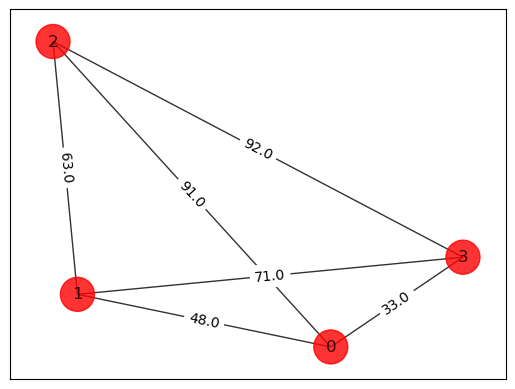

In [8]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

colors = ["r" for node in graph.nodes]
pos = [graph.nodes[node]["pos"] for node in graph.nodes]
draw_graph(graph, colors, pos)

In [9]:
mdl = Model(name="TSP")

x = dict()
for i in range(n):
    for j in range(n):
        x[(i,j)] = mdl.binary_var(name="x_{0}_{1}".format(i,j))

In [10]:
C_x = mdl.sum(
    M[i,j] * x[(i, k)] * x[(j, (k + 1) % n)]
    for i in range(n)
    for j in range(n)
    for k in range(n)
    if i != j
)

In [11]:
mdl.minimize(C_x)

In [12]:
for i in range(n):
    mdl.add_constraint(mdl.sum(x[i, p] for p in range(n)) == 1)
for p in range(n):
    mdl.add_constraint(mdl.sum(x[i, p] for i in range(n)) == 1)

In [13]:
qp = from_docplex_mp(mdl)
qubo = QuadraticProgramToQubo().convert(problem = qp)

In [14]:
def route_x(x):
    n = int(np.sqrt(len(x)))
    route = []
    for p in range(n):
        for i in range(n):
            if x[i * n + p]:
                route.append(i)
    return route

In [15]:
algorithm_globals.random_seed = 10598
# quantum_instance = QuantumInstance(Aer.get_backend("qasm_simulator"), seed_simulator=algorithm_globals.random_seed, seed_transpiler=algorithm_globals.random_seed)

qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(qubo)
print("\nQAOA:\n", qaoa_result)
qaoa_result = np.asarray([int(y) for y in reversed(list(qaoa_result))])
print("\nRoute\n", route_x(qaoa_result))

opt_end_time = time.time()
execution_time = opt_end_time - opt_start_time
print("optimizer execution time on sim: {:.2f} seconds".format(execution_time))


QAOA:
 fval=236.0, x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0, status=SUCCESS

Route
 [3, 2, 1, 0]
optimizer execution time on sim: 158.77 seconds
